In [1]:
import scipy.io
import pandas as pd
import numpy as np 
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score, cross_val_predict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
import scipy.stats as stats
from mat_preproc import preproc

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set_style("darkgrid")

In [61]:
# the mat file is generated by CRM_SN_vs_MN_imbalLDA_1450ms_order_proj.m

#Load in the MATLAB file with all the data
data = scipy.io.loadmat('data_CRM_SN_vs_MN_imbalLDA_order_proj_1.mat')
# data = scipy.io.loadmat('data_CRM_SN_vs_MN_imbalLDA_order_proj_2.mat')

print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'user_class_min_1', 'user_feat_1', 'user_prob_1', 'user_resp_1', 'user_source_1', 'user_tr_order_1', 'user_train_prob_1', 'user_weights_1'])


In [68]:
#Had to index them like this because there was an unnecessary dimension 

# user trail order
tr_order = data['user_tr_order_1'][0]

# projection scores
proj_score = data['user_prob_1'][0]

# source and response label
source_label = data['user_source_1'][0]
resp_label = data['user_resp_1'][0]

# features, group the channels and average over the windows,
# those are called features, and we use the features for training
behav_feat = data['user_feat_1'][0]

# Encodings for Each Label

## *source information*

1. SC (Source Correct)
2. CR (Correct Rejection)
3. SI (Source Incorrect)
4. Miss 
5. FA  (False Alarm)

## *label for the source response*

1. RS (Remember Source)
2. RO (Remember Other)
3. F (Familiarity)
4. MN (Maybe New) 
5. SN (Sure New)


In [17]:
# class attributes
source_info = ["SC", "CR", "SI", "M", "FA"]
response_info = ["RS", "RO", "F", "MN", "SN"]

# the x-axis on the projection graph
x_axis = [(1, 1), (3, 1), (5, 1), (1, 2), (5, 2), (1, 3), (3, 3), (5, 3), (4, 4), (2, 4), (4, 5), (2, 5)]

In [18]:
for source, resp in x_axis:
    print(f"{source_info[source-1]}-{response_info[resp-1]}")

SC-RS
SI-RS
FA-RS
SC-RO
FA-RO
SC-F
SI-F
FA-F
M-MN
CR-MN
M-SN
CR-SN


# Preproc

In [19]:
# multiple group
file_path = "data_CRM_SN_vs_MN_imbalLDA_order_proj_1.mat"
file_path = "data_CRM_SN_vs_MN_imbalLDA_order_proj_2.mat"
data_preproc = preproc(file_path, 2)
pos1, neg1 = data_preproc.filter_index(2,5,2,4)
pos2, neg2 = data_preproc.filter_index(4,5,4,4)
pos_idx, neg_idx = data_preproc.merge_two_class(pos1, neg1, pos2, neg2)
X, y, subject = data_preproc.get_data_by_index(pos_idx, neg_idx)
X.shape

(2802, 72)

In [20]:
subject.shape

(2802,)

In [21]:
y.shape

(2802,)

# trainning - `CRSN` v.s. `CRMN`

This has limited performance since `CRSN` and `CRMN` are only a subset of the `SN` and `MN` categories. To fully train on the `SN` and `MN` class, we need to merge `CRSN` and `MSN` and `CRMN` and `MMN` together.

In [22]:
data_pre = preproc(file_path, 2)
pos_idx, neg_idx = data_pre.filter_index(2,5,2,4)
X, y, subject = data_pre.get_data_by_index(pos_idx, neg_idx)

logo = LeaveOneGroupOut()

print(f"there are {logo.get_n_splits(X, y, subject)} groups")

there are 24 groups


In [23]:
LDA = LinearDiscriminantAnalysis(shrinkage = 0, solver = 'lsqr')
scores = cross_val_score(LDA, X, y, cv=logo, groups=subject)
scores.mean()

0.6073804804332871

In [24]:
LDA = LinearDiscriminantAnalysis(shrinkage = 'auto', solver = 'eigen')
pred = cross_val_predict(LDA, X, y, cv=logo, groups=subject)
accuracy_score(y, pred)

0.6297390448055146

# Trainning - SN v.s. MN

In [40]:
data_preproc = preproc(file_path, 2)
# combine SN and MN
pos1, neg1 = data_preproc.filter_index(2,5,2,4)
pos2, neg2 = data_preproc.filter_index(4,5,4,4)

pos_idx, neg_idx = data_preproc.merge_two_class(pos1, neg1, pos2, neg2)
X, y, subject = data_preproc.get_data_by_index(pos_idx, neg_idx)

logo = LeaveOneGroupOut()

scores = []

for train_idx, test_idx in logo.split(X, y, subject):
    X_train, y_train = X[train_idx,:], y[train_idx]
    X_test, y_test = X[test_idx,:], y[test_idx]
    LDA = LinearDiscriminantAnalysis(shrinkage = 'auto', solver = 'eigen')
    LDA.fit(X_train, y_train)
    scores.append(LDA.score(X_test, y_test))
scores = np.array(scores)

0.5421

In [41]:
LDA = LinearDiscriminantAnalysis(shrinkage = "auto", solver = 'eigen')
scores = cross_val_score(LDA, X, y, cv=logo, groups=subject)
scores.mean()

0.6149308324541386

In [42]:
X.shape

(2802, 72)

In [43]:
LDA = LinearDiscriminantAnalysis(shrinkage = "auto", solver = 'eigen')
pred = cross_val_predict(LDA, X, y, cv=logo, groups=subject)
accuracy_score(y, pred)

0.6370449678800857

# Testing the multiclass projection onto this classifier

In Keuida's code, the projection are calculated within fold. e.g, each participant's projection is based the LDA trained on the rest of the participants' data, instead of fitting it directly. Therefore, we might need to do the manual fitting in each fold of the LOSO.

In [51]:
np.unique(subject, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 21., 22., 23., 24., 25., 26., 27.]),
 array([ 64,  37,  35,  78, 137,  69,  59, 147,  62, 169,  56, 150, 139,
        159,  64, 135, 119,  82, 163, 150, 154,  84, 181,  45, 115, 149]))

In [53]:
projections = []
for train_idx, test_idx in logo.split(X, y, subject):
    # this LOSO follows the sequence of ppl presented in subject
    X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
    LDA.fit(X_train, y_train)
    projection = LDA.decision_function(X_test)
    projections.append(projection)
projections = np.concatenate(projections)

In [60]:
np.concatenate(data_preproc.filter_index_single_class(1,1)).shape

(9685,)

In [55]:
len(projections)

2802

In [29]:
# fitted on the SN vs. MN clf
LDA.fit(X, y)

LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen')

In [30]:
x_name = np.array([f"{source_info[s-1]}-{response_info[r-1]}" for s, r in x_axis])

In [36]:
projection = []

for source, response in x_axis:
    idx = data_preproc.filter_index_single_class(source,response)
    X, y = data_preproc.get_data_by_index_single_class(idx)
    projection.append(LDA.decision_function(X))
    
projection = np.array(projection, dtype=object)

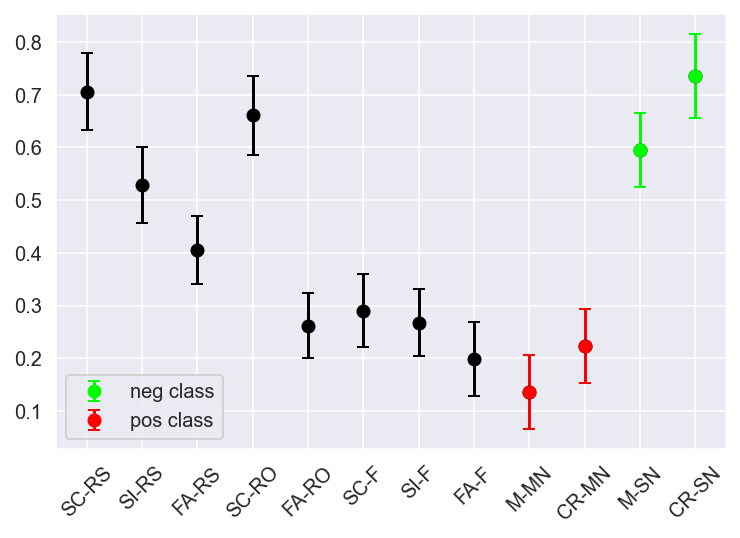

In [37]:
pos_idx = [10, 11]
neg_idx = [8, 9]

summary_stats = []
for proj in projection:
    mean = proj.mean()
    std = proj.std()
    summary_stats.append((mean, std))
summary_stats = np.array(summary_stats)

plt.errorbar(x_name, summary_stats[:,0], yerr = summary_stats[:,1]/10,
             fmt='o', capsize=3, c = 'black')
# pos
plt.errorbar(x_name[pos_idx], summary_stats[pos_idx,0],
             yerr = summary_stats[pos_idx,1]/10 , fmt='o', capsize=3, c = 'lime', label="neg class")
# neg
plt.errorbar(x_name[neg_idx], summary_stats[neg_idx,0],
             yerr = summary_stats[neg_idx,1]/10 , fmt='o', capsize=3, c = 'red', label="pos class")

_ = plt.xticks(rotation=45)
plt.legend()